In [1]:
import os
print(os.getcwd())
import matplotlib.pyplot as plt
import cv2
from realsense_sensor import RealsenseSensor
import imutils
import numpy as np
import cv_utils
import urx
import matplotlib.pyplot as plt
import time
import sys
import quaternion

/home/dominik/git/TA


In [2]:
cam = RealsenseSensor("realsense_config.json")



2020-05-29 17:04:06.724 | INFO     | realsense_sensor:__init__:53 - Cam <pyrealsense2.device: Intel RealSense D415 (S/N: 849412060288)> connected.


In [3]:
cam.start()

2020-05-29 17:04:07.075 | INFO     | realsense_sensor:start:97 - Realsense stream started.


In [4]:
img, d = cam.frames()

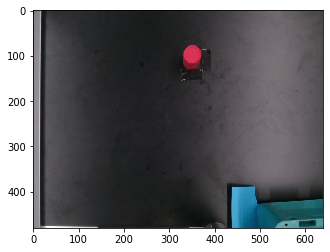

In [5]:
plt.imshow(img)

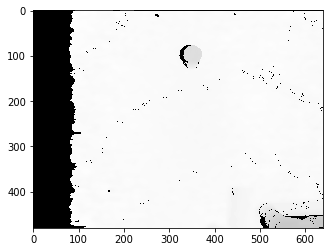

In [6]:
plt.imshow(d, cmap="gray")

In [7]:
intrinsics = cam.getIntrinsics()

In [8]:
intrinsics["px"]

311.8759765625

In [9]:
#init robot
rob = urx.Robot("192.168.0.105")
time.sleep(1)
rob.set_payload(2)
rob.set_tcp([0,0,0.23,0,0,0])

In [3]:
print(rob.getj())

[-1.5705655256854456, -0.9668362776385706, -1.9208563009845179, -1.7259982267962855, 1.5705300569534302, 3.1411571502685547]


In [15]:
def gripper_close():
    rob.set_digital_out(0,True)
    rob.set_digital_out(1,False)
    
def gripper_open():
    rob.set_digital_out(0,False)
    rob.set_digital_out(1,True)
    
def homing(a=0.05, v=0.05):
    
    home_posej=[-1.570517365132467, -0.9668362776385706, -1.920892063771383, -1.72593862215151, 1.5705060958862305, 3.1412529945373535]
    rob.movej(home_posej, a, v)
    
def bin_pose(a=0.05, v=0.05):
     
    bin_posej= [-2.8303948084460657, -1.5774520079242151, -2.2575133482562464, -0.8941767851458948, 1.558881402015686, 3.4544622898101807]
    rob.movej(bin_posej, a, v)
    
def graspit(object_pose, a=0.05, v=0.05):
    
    #intermediate_pose (Pose 10cm überhalb de  objekts)
    intermediate_pose = object_pose.copy()
    intermediate_pose[2] = intermediate_pose[2] + 0.1
    
    rob.movel(intermediate_pose, a,v)    
    
    #greifer auf
    gripper_open()
    
    #objekt_pose
    rob.movel(object_pose, a, v)
    
    #greifer zu
    gripper_close()
    
    #intermediate_pose
    rob.movel(intermediate_pose, a,v)    
    

def transform_grasp(grasp_cam):
    
    # ------ Hand-eye-calib
    t = np.array([0.0399475058562, 0.0763548299422, 0.120016693008])
    q = np.array([0.00304730943873, 0.0013088369074, -0.0438268247166, 0.999033638216])
    q_ = np.array([quaternion.from_float_array(q)])
    R = quaternion.as_rotation_matrix(q_)[0]

    #R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    #print(R)
    #t = np.array([-0.04, 0.07, 0.122])

    T_f_k = np.array([[R[0][0], R[0][1], R[0][2], t[0]],[R[1][0], R[1][1], R[1][2], t[1]],[R[2][0], R[2][1], R[2][2], t[2]],[0, 0, 0, 1]])
    print("hand-eye:")
    print(T_f_k)
    # ------

    # ------ uild actual robot pose homogen
    #T_f_k = np.linalg.inv(T_f_k)
    # get current robot pose as homogeneous matrix
    T_w_f = rob.get_pose().array
    print("actual-pose:")
    print(T_w_f)
    #print(T_w_f)
    # ------
    T_rotx = np.array([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
    print("T_rotx:")
    print(T_rotx)


    # ------ whole transform
    T_w_k = T_w_f @  T_f_k @T_rotx 
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    print("complete tfrom")
    print(T_w_k)
    # ------

    # transform grasp point_vam to grasp_world
    grasp_cam_homo = np.array([grasp_cam[0], grasp_cam[1], grasp_cam[2], 1])
    print("grasp cam homo")
    print(grasp_cam_homo)
    grasp_world = T_w_k @ grasp_cam_homo
    # ------

    print(grasp_world[0:3])
    # grasp_desired = [-0.096, -0.46, 0.031]

    return grasp_world[0:3]
    
def get_grasp():
    object_type = input("Welches Objekt willst du greifen? r: Rechteck, c: Kreis, a: beliebig   ")

    img, d = cam.frames()

    # check which object to be grasped
    if object_type == "r":
        grasp_point = cv_utils.find_rects_in_image(img, d, intrinsics=cam.getIntrinsics())
    elif object_type == "c":
        grasp_point = cv_utils.findCirclesInMask(img, d, intrinsics=cam.getIntrinsics())
    elif object_type == "a":
        grasp_point = cv_utils.calcGraspPointContours(img, d, intrinsics=cam.getIntrinsics())
    else:
        print("Solche Objekte kann ich nicht.")
        sys.exit()
    if grasp_point:
        x,y,z = grasp_point
        plt.imshow(img)
        print("Griffpunkt in Kamerakoordinaten: ",x,y,z)

        # griffpunkt 
        grasp_pos_cam = np.array([x,y,z])
        return grasp_pos_cam
    return None
    

In [ ]:
homing()

grasp_cam = get_grasp()
print(grasp_cam)
grasp_world = transform_grasp(grasp_cam)
print(grasp_world)

object_pose=[grasp_world[0], grasp_world[1]+0.02, -0.24, 3.1400406207576754, 2.1426800889571524e-05, -4.4484531950045126e-05]




graspit(object_pose,0.25,0.25)

bin_pose(0.25,0.25)

gripper_open()

homing(0.25, 0.25)

# grasp_desired = [-0.096, -0.46, 0.031]

Welches Objekt willst du greifen? r: Rechteck, c: Kreis, a: beliebig   c
Griffpunkt in Kamerakoordinaten:  -0.16554365025989942 0.02405944799823709 -0.5408979690804774
[-0.166  0.024 -0.541]
hand-eye:
[[-1.    -0.006  0.002  0.04 ]
 [ 0.006 -0.996 -0.088  0.076]
 [ 0.003 -0.088  0.996  0.12 ]
 [ 0.     0.     0.     1.   ]]
actual-pose:
[[ 1.     0.005  0.006 -0.106]
 [ 0.006 -0.995 -0.099 -0.264]
 [ 0.005  0.099 -0.995  0.236]
 [ 0.     0.     0.     1.   ]]
T_rotx:
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]
complete tfrom
[[-1.     0.012 -0.007 -0.065]
 [-0.012 -1.     0.012 -0.352]
 [-0.007  0.012  1.     0.124]
 [ 0.     0.     0.     1.   ]]
grasp cam homo
[-0.166  0.024 -0.541  1.   ]
[ 0.104 -0.38  -0.415]
[ 0.104 -0.38  -0.415]


In [30]:
homing()

In [7]:
object_posel=[-0.09966076580186983, -0.4846129278265809, 0.009738334083341987, 3.1400406207576754, 2.1426800889571524e-05, -4.4484531950045126e-05]
print(object_posel)
intermediate_pose = object_posel
intermediate_pose[2] = intermediate_pose[2] + 0.1
print(intermediate_pose)

[-0.09966076580186983, -0.4846129278265809, 0.009738334083341987, 3.1400406207576754, 2.1426800889571524e-05, -4.4484531950045126e-05]
[-0.09966076580186983, -0.4846129278265809, 0.10973833408334199, 3.1400406207576754, 2.1426800889571524e-05, -4.4484531950045126e-05]


In [45]:
homing()


In [16]:
gripper_open()

Welches Objekt willst du greifen? r: Rechteck, c: Kreis, a: beliebig   c
Griffpunkt in Kamerakoordinaten:  0.035287889801343786 0.12431950903837874 -0.5398775740545623
[ 0.03528789  0.12431951 -0.53987757]
[-0.112 -0.416  0.671]


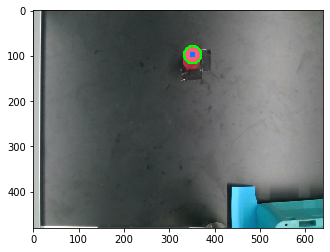

In [11]:
grasp_cam = get_grasp()
print(grasp_cam)
grasp_world = transform_grasp(grasp_cam)
print(grasp_world)


In [41]:
rob.get_pose().array

array([[ 0.997,  0.066, -0.037, -0.096],
       [ 0.066, -0.998,  0.001, -0.46 ],
       [-0.037, -0.004, -0.999,  0.031],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

Welches Objekt willst du greifen? r: Rechteck, c: Kreis, a: beliebig   c
Griffpunkt in Kamerakoordinaten:  -0.015323146122702185 -0.06537776392762085 0.5190000534057617


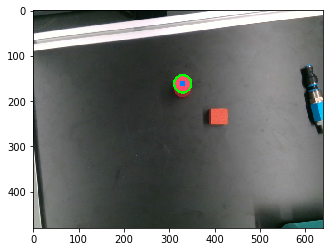

In [5]:
import scipy
import numpy as np
import quaternion
from scipy.spatial.transform import Rotation as R
rotm = R.from_quat([0.0013088369074, -0.0438268247166, 0.999033638216, 0.00304730943873])
print(rotm.as_matrix())

q = np.array([0.00304730943873, 0.0013088369074, -0.0438268247166, 0.999033638216])
q_ = np.array([quaternion.from_float_array(q)])
RR = quaternion.as_rotation_matrix(q_)[0]
print(RR)


[[-0.999978   -0.00620345  0.00234804]
 [ 0.005974   -0.99613985 -0.08757692]
 [ 0.00288225 -0.08756097  0.99615499]]
[[-0.999978   -0.00620345  0.00234804]
 [ 0.005974   -0.99613985 -0.08757692]
 [ 0.00288225 -0.08756097  0.99615499]]


In [14]:
grasp_cam = np.array([ 0.03528789,  0.12431951, -0.53987757])

# ------ Hand-eye-calib
t = np.array([0.0399475058562, 0.0763548299422, 0.120016693008])
q = np.array([0.00304730943873, 0.0013088369074, -0.0438268247166, 0.999033638216])
q_ = np.array([quaternion.from_float_array(q)])
R = quaternion.as_rotation_matrix(q_)[0]

#R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#print(R)
#t = np.array([-0.04, 0.07, 0.122])

T_f_k = np.array([[R[0][0], R[0][1], R[0][2], t[0]],[R[1][0], R[1][1], R[1][2], t[1]],[R[2][0], R[2][1], R[2][2], t[2]],[0, 0, 0, 1]])
print("hand-eye:")
print(T_f_k)
# ------

# ------ uild actual robot pose homogen
#T_f_k = np.linalg.inv(T_f_k)
# get current robot pose as homogeneous matrix
T_w_f = rob.get_pose().array
print("actual-pose:")
print(T_w_f)
#print(T_w_f)
# ------
T_rotx = np.array([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
print("T_rotx:")
print(T_rotx)


# ------ whole transform
T_w_k = T_w_f @  T_f_k @T_rotx 
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print("complete tfrom")
print(T_w_k)
# ------

# transform grasp point_vam to grasp_world
grasp_cam_homo = np.array([grasp_cam[0], grasp_cam[1], grasp_cam[2], 1])
print("grasp cam homo")
print(grasp_cam_homo)
grasp_world = T_w_k @ grasp_cam_homo
# ------

print(grasp_world[0:3])
# grasp_desired = [-0.096, -0.46, 0.031]

hand-eye:
[[-1.    -0.006  0.002  0.04 ]
 [ 0.006 -0.996 -0.088  0.076]
 [ 0.003 -0.088  0.996  0.12 ]
 [ 0.     0.     0.     1.   ]]
actual-pose:
[[ 1.     0.005  0.006 -0.106]
 [ 0.006 -0.995 -0.099 -0.264]
 [ 0.005  0.099 -0.995  0.236]
 [ 0.     0.     0.     1.   ]]
T_rotx:
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]
complete tfrom
[[-1.     0.012 -0.007 -0.065]
 [-0.012 -1.     0.012 -0.352]
 [-0.007  0.012  1.     0.124]
 [ 0.     0.     0.     1.   ]]
grasp cam homo
[ 0.035  0.124 -0.54   1.   ]
[-0.095 -0.483 -0.414]


In [30]:
np.linalg.inv(T_w_k)



array([[-1.   , -0.012, -0.007, -0.069],
       [-0.012,  1.   , -0.012,  0.353],
       [ 0.007, -0.011, -1.   ,  0.121],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [15]:
rob.get_pose().array

array([[ 0.99997099,  0.00517007,  0.00559377, -0.10643126],
       [ 0.00569885, -0.99506487, -0.09906278, -0.26429742],
       [ 0.005054  ,  0.09909178, -0.99506546,  0.2360742 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

[[ 0.999  0.019  0.03   0.143]
 [ 0.03  -0.001 -1.    -0.187]
 [-0.019  1.    -0.002  0.542]
 [ 0.     0.     0.     1.   ]]
[[-0.999 -0.028  0.03   0.188]
 [-0.033  0.088 -0.996 -0.306]
 [ 0.025 -0.996 -0.089  0.617]
 [ 0.     0.     0.     1.   ]]


In [65]:
[[-1.    -0.006  0.002]
 [ 0.006 -0.996 -0.088]
 [ 0.003 -0.088  0.996]]
[[ 0.059 -0.028  0.998 -0.111]
 [-0.992 -0.11   0.055  0.011]
 [ 0.108 -0.994 -0.034  0.416]
 [ 0.     0.     0.     1.   ]]
[[-0.056 -0.06   0.997  0.009]
 [ 0.992  0.111  0.062 -0.03 ]
 [-0.114  0.992  0.053  0.341]
 [ 0.     0.     0.     1.   ]]

array([[-0.995, -0.085,  0.045,  0.212],
       [-0.067,  0.948,  0.313, -0.108],
       [-0.069,  0.308, -0.949,  0.482],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [29]:
T_f_k

array([[-0.999978  , -0.00620345,  0.00234804,  0.03994751],
       [ 0.005974  , -0.99613985, -0.08757692,  0.07635483],
       [ 0.00288225, -0.08756097,  0.99615499,  0.12001669],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [60]:
print(T_w_k)

[[-9.27521441e-01  3.11857765e-05 -8.77427154e-04 -5.57309203e-03]
 [-8.42215528e-04  9.27147696e-01  2.95494904e-02 -1.29337507e-02]
 [-9.97570478e-04 -3.20163004e-02 -8.60687366e-01  6.84659330e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [26]:
R[2][0]

0.002882251988117295